# Cross Validation
This notebook describes how to do cross validation with simulation models.

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import lmfit   # Fitting lib
import math
import random 
import matplotlib.pyplot as plt

In [2]:
# Some useful functions

def reshapeData(matrix, indices, first_col=0):
    """
    Re-structures matrix as an array for just the rows
    in indices.
    """
    num_columns = np.shape(matrix)[1] - first_col
    trimmed_matrix = matrix[indices, first_col:]
    return np.reshape(trimmed_matrix, num_columns*len(indices))

def arrayDifference(matrix1, matrix2, indices):
    """
    Calculates matrix1 - matrix2 as a nX1 array for the rows
    specified in indices.
    """
    array1 = reshapeData(matrix1, indices)
    array2 = reshapeData(matrix2, indices)
    return (array1 - array2)

def calcRsq(observations, estimates, indices):
    """
    Computes RSQ for simulation results.
    :param 2d-np.array observations: non-time values
    :param 2d-np.array estimates: non-time values
    :param list-int indices:
    :return float:
    """
    array_residuals = arrayDifference(observations, estimates, indices)
    array_observations = reshapeData(observations, indices)
    return 1 - np.var(array_residuals)/np.var(array_observations)

def runSimulation(sim_time, num_points, parameters=None, road_runner=None, model=None):
    """
    Runs the simulation model rr for the parameters.
    :param int sim_time: time to run the simulation
    :param int num_points: number of timepoints simulated
    :param lmfit.Parameters parameters:
    :param tellurium.roadrunner.extended_roadrunner.ExtendedRoadRunner road_runner:
    :param str model:
    :return named_array:
    """
    if road_runner is None:
        road_runner = te.loada(model)
    else:
        road_runner.reset()
    if parameters is not None:
        parameter_dict = parameters.valuesdict()
        # Set the simulation constants for all parameters
        for constant in parameter_dict.keys():
            stmt = "road_runner.%s = parameter_dict['%s']" % (constant, constant)
            exec(stmt)
    return rr.simulate (0, sim_time, num_points)


In [3]:
# Experimental conditions
sim_time = 30
num_points = 15
noise_std = 1.0
num_folds = 3

In [4]:
# The simulation model
rr = te.loada("""
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
""")

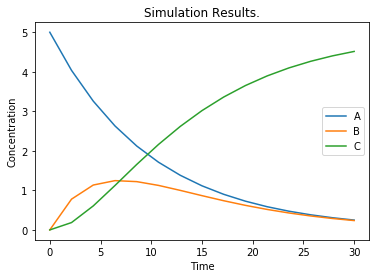

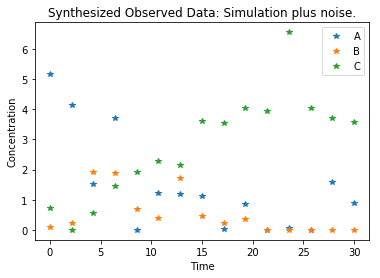

In [5]:
# Create the experimental data. We refer to these as the observations
data = runSimulation(sim_time, num_points, road_runner=rr)
num_cols = len(data.colnames) - 1

# Create some 'experimental' data 
x_data = data[:, 0]  # Times
obs_data = data.copy()
obs_data = obs_data[:,1:]   # Values of chemical species

for i in range (num_points):
    for j in range(num_cols):
        obs_data[i, j] = max(obs_data[i, j] + np.random.normal(0, noise_std, 1), 0)
        

# Plot the simulation data.
plt.plot (x_data, data[:, 1:])
plt.title("Simulation Results.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend(['A', 'B', 'C'])
plt.show() 

# Plot the observed data.
plt.plot (x_data, obs_data, marker='*', linestyle='None')
plt.title("Synthesized Observed Data: Simulation plus noise.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend(['A', 'B', 'C'])
plt.show() 


In [6]:
# Generates indices of training and test data
# by alternating between folds
def foldGenerator(num_points, num_folds):
   indices = range(num_points)
   for remainder in range(num_folds):
       test_indices = []
       for idx in indices:
         if idx % num_folds == remainder:
           test_indices.append(idx)
       train_indices = np.array(
           list(set(indices).difference(test_indices)))
       test_indices = np.array(test_indices)
       yield train_indices, test_indices

In [7]:
fold_generator = foldGenerator(num_points, num_folds)  # Create the iterator object
result_parameters = []
result_rsqs = []
for train_indices, test_indices in fold_generator:
    
    # This function is defined inside the loop because it references a loop variable
    def calcResiduals(parameters):
        """
        Runs a simulation with the specified parameters and calculates residuals
        for the train_indices.
        """
        sim_data = runSimulation(sim_time, num_points, road_runner=rr, parameters=parameters)
        sim_data = sim_data[:, 1:]  # Skip time
        return arrayDifference(obs_data, sim_data, train_indices)
 
    # Set the parameters
    parameters = lmfit.Parameters()
    parameters.add('k1', value=1, min=0, max=10)
    parameters.add('k2', value=1, min=0, max=10)
    # Estimate the parameters for this fold
    fitter = lmfit.Minimizer(calcResiduals, parameters)
    fitter_result = fitter.minimize(method='leastsq')
    result_parameters.append(fitter_result.params)
    # Run the simulation using
    # the parameters estimated using the training data.
    test_estimates = runSimulation(sim_time, num_points, road_runner=rr,
                                   parameters=fitter_result.params)
    test_estimates = test_estimates[:, 1:]
    # Calculate RSQ
    rsq = calcRsq(obs_data, test_estimates, test_indices)
    result_rsqs.append(rsq)
    

In [8]:
# R square values for each fold
print(result_rsqs)

[0.8280477776395135, 0.8171429594774615, 0.7580108264619818]


In [9]:
# Parameters for each fold
for parameter in result_parameters:
    print(parameter)

Parameters([('k1', <Parameter 'k1', value=0.1440954968913044 +/- 0.0236, bounds=[0:10]>), ('k2', <Parameter 'k2', value=0.2346893931973254 +/- 0.0631, bounds=[0:10]>)])
Parameters([('k1', <Parameter 'k1', value=0.1255461813741171 +/- 0.0186, bounds=[0:10]>), ('k2', <Parameter 'k2', value=0.19846206063999006 +/- 0.0464, bounds=[0:10]>)])
Parameters([('k1', <Parameter 'k1', value=0.10765332029142927 +/- 0.0133, bounds=[0:10]>), ('k2', <Parameter 'k2', value=0.21125269354994258 +/- 0.0475, bounds=[0:10]>)])
